In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#import arkadia
import datetime as dtm
from dateutil.parser import parse
from datetime import date
from datetime import datetime, timedelta
from workalendar.europe import Germany
%matplotlib qt

"""
Working Directory
"""
#PATH = r"C:/Users/owen_/Documents/git/exjobb"
PATH = r"F:/Documents/git/exjobb"
DATAPATH = PATH + "/data"

In [2]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
def sigmoid_transform(x,w):
    return (1/(1+np.exp(x*w)))
def outlier_removal(x, quantile_lower, quantile_upper):
    if x > quantile_upper:
        return quantile_upper
    elif x < quantile_lower:
        return quantile_lower
    else:
        return x

In [3]:
def softBasis(center,width, total_length, power):
    #leftSide= np.max(0, center-width)
    #rightSide = np.min(center+width, total_length)
    #dummyvar = np.zeros([width*2])

    output = np.zeros(total_length)
    for i in range(total_length):
        output[i] = np.max([0,(1-((i-center+20)/width)**power)])

    return output

In [4]:

def GPRegMonthBased(Xtrain, Xtest, ytrain, ytest, bigkernel, i, plots=False,return_model = False):
#nsamples = 10000 #n=50112 is max
    print('  ')
    print(f'Month {i}')
    gpr3 = gp.GaussianProcessRegressor(kernel=bigkernel).fit(Xtrain,ytrain)
    #gpr = gp.GaussianProcessRegressor(kernel1).fit(X[idx:idx+dist,:],y[idx:idx+dist])
    print('score (R^2) subsample:', gpr3.score(Xtrain, ytrain))

    print('kernel:', gpr3.kernel_)
    #pred = gpr3.predict(Xtrain)
    #plt.plot(pred[0]-y)
    #print('score (R^2):', gpr.score(X, y))


    samp_y1 = gpr3.predict(Xtrain)
    if plots:
        plt.figure()
        plt.plot(samp_y1 - ytrain)
        plt.title(f"residuals traindata, Month {i} ")
        plt.show()
        plt.figure()
        plt.plot(samp_y1)
        plt.plot(ytrain)
        plt.title('Testdata')
        plt.legend(['pred', 'y'])
        plt.show()
    MSEtrain = sum((samp_y1-ytrain)**2)/len(samp_y1)
    MAEtrain = sum(abs(samp_y1-ytrain))/len(samp_y1)
    print('MSE train:', MSEtrain)
    print('MAE train:', MAEtrain)

    samp_y = gpr3.predict(Xtest)
    if plots:
        plt.figure()
        plt.plot(samp_y - ytest)
        plt.title(f"residuals Testdata, Month {i}")
        plt.show()
        plt.figure()
        plt.plot(samp_y)
        plt.plot(ytest)
        plt.title('Testdata')
        plt.legend(['pred', 'y'])
        plt.show()
    MSEtest = sum((samp_y-ytest)**2)/len(samp_y)
    MAEtest = sum(abs(samp_y-ytest))/len(samp_y)
    print('MSE test:', MSEtest)
    print('MAE test:', MAEtest)
    resultdict = {'MSEtrain': MSEtrain, 'MAEtrain': MAEtrain, 'MSEtest': MSEtest,'MAEtest': MAEtest}
    print(resultdict)
    if return_model:
        return resultdict, samp_y, gpr3
    else:
        return resultdict, samp_y

In [5]:
#Getting prices from SMARD
day_ahead_prices = pd.read_csv(DATAPATH + "/Day_ahead_prices.csv")
daprice_germany_new = pd.DataFrame()
sp1 = day_ahead_prices.index[-day_ahead_prices['Germany/Luxembourg[€/MWh]'].isna()]
sp2 = day_ahead_prices.index[-day_ahead_prices['Germany/Austria/Luxembourg[€/MWh]'].isna()]
sp3 = day_ahead_prices.index[day_ahead_prices['Germany/Luxembourg[€/MWh]'].isna() & day_ahead_prices['Germany/Austria/Luxembourg[€/MWh]'].isna()]

daprice_germany_new['Price'] = pd.concat([day_ahead_prices['Germany/Luxembourg[€/MWh]'][sp3], day_ahead_prices['Germany/Austria/Luxembourg[€/MWh]'][sp2],day_ahead_prices['Germany/Luxembourg[€/MWh]'][sp1]])
timelist = ['Hour', 'Datetime', 'Month','Year','Weekclass','Weekday','Grouped_daytype']
for timeitem in timelist:
    daprice_germany_new[timeitem] = day_ahead_prices[timeitem]
daprice_germany_new.plot(x='Datetime', y='Price')

spot_prices = daprice_germany_new
del spot_prices['Weekday']
spot_prices['Weekday'] = spot_prices['Weekclass'].apply(lambda x: int(x))
del spot_prices['Weekclass']
spot_prices = spot_prices.iloc[120:,:].reset_index()

datetime = pd.DatetimeIndex(spot_prices['Datetime'], freq='H')
datetime.rename('index')
del spot_prices['index'], spot_prices['Datetime']
spot_prices = spot_prices.set_index(datetime)
print(spot_prices)


                     Price  Hour  Month  Year   Grouped_daytype  Weekday
Datetime                                                                
2015-01-06 00:00:00  30.02     0      1  2015           Holiday        7
2015-01-06 01:00:00  30.57     1      1  2015           Holiday        7
2015-01-06 02:00:00  30.25     2      1  2015           Holiday        7
2015-01-06 03:00:00  30.29     3      1  2015           Holiday        7
2015-01-06 04:00:00  30.63     4      1  2015           Holiday        7
...                    ...   ...    ...   ...               ...      ...
2020-09-23 19:00:00  60.80    19      9  2020  Tuesday-Thursday        3
2020-09-23 20:00:00  53.01    20      9  2020  Tuesday-Thursday        3
2020-09-23 21:00:00  49.89    21      9  2020  Tuesday-Thursday        3
2020-09-23 22:00:00  39.02    22      9  2020  Tuesday-Thursday        3
2020-09-23 23:00:00  32.45    23      9  2020  Tuesday-Thursday        3

[50112 rows x 6 columns]


In [6]:
for val in [0.005, 0.01, 0.025, 0.05, 0.95, 0.975, 0.99, 0.995]:
    print(spot_prices['Price'].quantile(val))


-19.914450000000002
-5.9723
1.0
10.01
60.32
68.5
77.75
85.97889999999998


In [7]:
monthlen = [26*24,]
center = [26*24-31*12,]
width = [31*12,]
monthlens = [24*31, 24*28, 24*31, 24*30, 24*31, 24*30, 24*31, 24*31, 24*30, 24*31, 24*30, 24*31]
year1 = [26, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
year2 = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
year3 = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
year4 = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
year5 = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
year6 = [31, 28, 31, 30, 31, 30, 31, 31, 23]
allyears = year1+year2+year3+year4+year5+year6
pos=24*26
for i in range(1,len(allyears)-1):
    monthlen.append(allyears[i]*24)
    center.append(pos+monthlen[i]/2)
    width.append(monthlen[i]/2)
    pos = pos+monthlen[i]
monthlen.append(23*24)
center.append(pos+30*12)
width.append(30*12)


jan_OH = np.zeros(50112)
feb_OH = np.zeros(50112)
mar_OH = np.zeros(50112)
apr_OH = np.zeros(50112)
may_OH = np.zeros(50112)
jun_OH = np.zeros(50112)
jul_OH = np.zeros(50112)
aug_OH = np.zeros(50112)
sep_OH = np.zeros(50112)
oct_OH = np.zeros(50112)
nov_OH = np.zeros(50112)
dec_OH = np.zeros(50112)

for i in range(len(allyears)):
    if i % 12 == 1:
        jan_OH = jan_OH + softBasis(center[i], width[i], 50112, 4)
    elif i % 12 == 2:
        feb_OH = feb_OH + softBasis(center[i], width[i], 50112, 4)
    elif i % 12 == 3:
        mar_OH = mar_OH + softBasis(center[i], width[i], 50112, 4)
    elif i % 12 == 4:
        apr_OH = apr_OH + softBasis(center[i], width[i], 50112, 4)
    elif i % 12 == 5:
        may_OH = may_OH + softBasis(center[i], width[i], 50112, 4)
    elif i % 12 == 6:
        jun_OH = jun_OH + softBasis(center[i], width[i], 50112, 4)
    elif i % 12 == 7: 
        jul_OH = jul_OH + softBasis(center[i], width[i], 50112, 4)
    elif i % 12==8:
        aug_OH = aug_OH + softBasis(center[i], width[i], 50112, 4)
    elif i % 12==9:
        sep_OH = sep_OH + softBasis(center[i], width[i], 50112, 4)
    elif i % 12 == 10:
        oct_OH = oct_OH + softBasis(center[i], width[i], 50112, 4)
    elif i % 12 == 11:
        nov_OH = nov_OH + softBasis(center[i], width[i], 50112, 4)
    elif i % 12==0:
        dec_OH = dec_OH + softBasis(center[i], width[i], 50112, 4)

soft_month_OH_np = np.array([jan_OH, feb_OH, mar_OH, apr_OH, may_OH, jun_OH, jul_OH, aug_OH, sep_OH, oct_OH, nov_OH, dec_OH]).transpose()
print(soft_month_OH_np.shape)
soft_month_OH = pd.DataFrame(soft_month_OH_np, columns=[f"Months_{i+1}" for i in range(12)])
soft_month_OH = soft_month_OH.set_index(datetime)
print(soft_month_OH.shape)
print(soft_month_OH.index)
'jan_OH', 'feb_OH','mar_OH','apr_OH','may_OH','jun_OH','jul_OH','aug_OH','sep_OH','oct_OH','nov_OH','dec_OH'

(50112, 12)
(50112, 12)
DatetimeIndex(['2015-01-06 00:00:00', '2015-01-06 01:00:00',
               '2015-01-06 02:00:00', '2015-01-06 03:00:00',
               '2015-01-06 04:00:00', '2015-01-06 05:00:00',
               '2015-01-06 06:00:00', '2015-01-06 07:00:00',
               '2015-01-06 08:00:00', '2015-01-06 09:00:00',
               ...
               '2020-09-23 14:00:00', '2020-09-23 15:00:00',
               '2020-09-23 16:00:00', '2020-09-23 17:00:00',
               '2020-09-23 18:00:00', '2020-09-23 19:00:00',
               '2020-09-23 20:00:00', '2020-09-23 21:00:00',
               '2020-09-23 22:00:00', '2020-09-23 23:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=50112, freq='H')


('jan_OH',
 'feb_OH',
 'mar_OH',
 'apr_OH',
 'may_OH',
 'jun_OH',
 'jul_OH',
 'aug_OH',
 'sep_OH',
 'oct_OH',
 'nov_OH',
 'dec_OH')

In [8]:
#creating daytype groups and calculating H2M ratios for each hour
#price_df['Grouped_daytype'] = price_df['Weekday'].apply(weekday_definition)
price_df = spot_prices
print(price_df)

month_avg = (price_df[['Price','Year','Month']].groupby(by=['Year','Month']).mean()
            .rename(columns={'Price':'Monthly_avg'}))

price_df = price_df.reset_index().merge(month_avg, on=['Year','Month']).set_index(datetime)
price_df['H2M_ratios'] = price_df['Price']/price_df['Monthly_avg']

                     Price  Hour  Month  Year   Grouped_daytype  Weekday
Datetime                                                                
2015-01-06 00:00:00  30.02     0      1  2015           Holiday        7
2015-01-06 01:00:00  30.57     1      1  2015           Holiday        7
2015-01-06 02:00:00  30.25     2      1  2015           Holiday        7
2015-01-06 03:00:00  30.29     3      1  2015           Holiday        7
2015-01-06 04:00:00  30.63     4      1  2015           Holiday        7
...                    ...   ...    ...   ...               ...      ...
2020-09-23 19:00:00  60.80    19      9  2020  Tuesday-Thursday        3
2020-09-23 20:00:00  53.01    20      9  2020  Tuesday-Thursday        3
2020-09-23 21:00:00  49.89    21      9  2020  Tuesday-Thursday        3
2020-09-23 22:00:00  39.02    22      9  2020  Tuesday-Thursday        3
2020-09-23 23:00:00  32.45    23      9  2020  Tuesday-Thursday        3

[50112 rows x 6 columns]


In [9]:
plt.figure()
daterange = pd.date_range("2015-03-01", "2015-03-07 23:00", freq="H")
for i in ['2015','2016','2017','2018','2019']:
    plt.plot(daterange, price_df[f"{i}-03-01":f"{i}-03-7"]['Price'])
plt.ylabel = 'Price €'

plt.legend(['2015','2016','2017','2018','2019'])
plt.show()

In [10]:
#averaging over daytupe groups
averaged_profiles = (price_df[['H2M_ratios','Grouped_daytype','Month','Hour']]
                    .groupby(by=['Grouped_daytype','Month','Hour']).mean())




In [11]:
for val in [0.005, 0.01, 0.025, 0.05, 0.95, 0.975, 0.99, 0.995]:
    print(price_df['H2M_ratios'].quantile(val))


-0.662448124499736
-0.22214638024888833
0.03450274079651605
0.33194950762037845
1.5916647990523183
1.7431396644256185
1.9787128388706696
2.1858836328950915


In [12]:
price_df['H2M_ratios 95th'] = price_df['H2M_ratios'].apply(lambda x: outlier_removal(x, price_df['H2M_ratios'].quantile(0.001), price_df['H2M_ratios'].quantile(0.099)))

In [13]:
#Plotting average H2M weights per daytype group.
#Some nicer plotting here!! Maybe a subplot (4 x 3) where each daytype (Mon,Tues-Thur,Fri,Sat,Sun) are plotted 
#for each month.

plot_month=9

plt.figure()
fig1 = plt.plot(averaged_profiles.loc[('Monday',plot_month)])
fig1 = plt.plot(averaged_profiles.loc[('Tuesday-Thursday',plot_month)])
fig1 = plt.plot(averaged_profiles.loc[('Friday',plot_month)])
fig1 = plt.plot(averaged_profiles.loc[('Saturday',plot_month)])
fig1 = plt.plot(averaged_profiles.loc[('Sunday',plot_month)])
#fig1 = plt.plot(averaged_profiles.loc[('Holiday',plot_month)])

plt.legend(['Monday', 'Tuesday-Thursday', 'Friday', 'Saturday','Sunday','Holiday'])
plt.show()

In [14]:
### Load all data
actprod = pd.read_csv(DATAPATH + "/actprod.csv")
#actprod_4res = pd.read_csv(DATAPATH+"/actprod_4res.csv")
actcons = pd.read_csv(DATAPATH+"/actcons.csv")
#actcons_4res = pd.read_csv(DATAPATH+"/actcons_4res.csv")
foreprod = pd.read_csv(DATAPATH+"/foreprod.csv")
#foreprod_4res = pd.read_csv(DATAPATH+"/foreprod_4res.csv")
forecons = pd.read_csv(DATAPATH+"/forecons.csv")
#forecons_4res = pd.read_csv(DATAPATH+"/forecons_4res.csv")

netimportexport = pd.read_csv(DATAPATH+"/Net_import_export.csv")
installcapacity = pd.read_csv(DATAPATH+"/installed_capacity.csv")
capacity_extended = pd.read_csv(DATAPATH+"/capacity_extended.csv")

In [15]:
normalized_productions = pd.DataFrame([])
columns_prod = actprod.columns[0:12]
columns_cap = capacity_extended.columns[0:12]
columns_prod_dates = actprod.columns[12:]
columns_cap_dates = [col for col in capacity_extended.columns if col not in columns_cap]
non_plot_elements = ['Datetime', 'Weekday', 'Weekclass', 'Year', 'Month', 'Hour',
       'Grouped_daytype']

for col in range(12):
    normalized_productions[columns_prod[col]] = actprod[columns_prod[col]] / capacity_extended[columns_cap[col]][:actprod.shape[0]]
normalized_productions.plot(marker='.')    
for col in normalized_productions.columns:
    for i in range(normalized_productions[col].shape[0]):
        if normalized_productions[col][i] > 1:
            normalized_productions[col][i] = 1
        elif normalized_productions[col][i] < 0:
            normalized_productions[col][i] = 0
            
for col in range(7):
    normalized_productions[columns_prod_dates[col]] = actprod[columns_prod_dates[col]]
plt.figure()
for col in normalized_productions.columns:
    if col not in non_plot_elements:
        plt.plot(np.linspace(0, normalized_productions.shape[0], normalized_productions.shape[0]), normalized_productions[col])
plt.show()

normalized_productions['Wind total[MWh]'] = (actprod['Wind onshore[MWh]'] + actprod['Wind offshore[MWh]'])/(capacity_extended['Wind onshore[MW]']+capacity_extended['Wind offshore[MW]'])
normalized_productions['Coal total[MWh]'] = (actprod['Fossil hard coal[MWh]']+actprod['Fossil brown coal[MWh]'])/(capacity_extended['Fossil hard coal[MW]']+capacity_extended['Fossil brown coal[MW]'])



In [16]:
residual_load_columns = ['Nuclear', 'Fossil brown coal', 'Fossil hard coal','Fossil gas', 'Hydro pumped storage']

newlist =[]
newlist2 = []
for i in residual_load_columns:
    item1 = i+'[MWh]'
    item2 = i+'[MW]'
    newlist.append(item1)
    newlist2.append(item2)
residual_load = actprod[newlist].sum(axis=1)
residual_load_capacity = capacity_extended[newlist2].sum(axis=1)
normalized_productions['Residual load[MWh]'] = residual_load/residual_load_capacity
normalized_productions['Residual load[MWh]'].head()

0    0.316061
1    0.297603
2    0.287338
3    0.276492
4    0.277804
Name: Residual load[MWh], dtype: float64

In [17]:
netchange = netimportexport.iloc[:,0:19].sum(axis=1)
print(netchange.head())
netchange = netchange.apply(lambda x: 2*(sigmoid_transform(x, 1/4000)-0.5))
plt.plot(netchange)


0    5131.0
1    4989.0
2    5091.0
3    5023.0
4    5322.0
dtype: float64


In [18]:
#onehot encoding of day types and month types
normalized_productions = normalized_productions.set_index(pd.DatetimeIndex(normalized_productions['Datetime'], freq='H'))
onehot_daytypes = pd.get_dummies(normalized_productions.resample(rule='H').max()['Grouped_daytype'], prefix='Weekdays')
onehot_monthtypes = pd.get_dummies(normalized_productions.resample(rule='H').max()['Month'], prefix='Months')
onehot_hours = pd.get_dummies(normalized_productions.resample(rule='H').max()['Hour'], prefix='Hours')
onehot_years = pd.get_dummies(normalized_productions.resample(rule='H').max()['Year'], prefix='Year')
onehot_hours_np = onehot_hours.to_numpy()
onehot_months_np = onehot_monthtypes.to_numpy()
onehot_daytype_np = onehot_daytypes.to_numpy()
onehot_year_np = onehot_years.to_numpy()

In [19]:
print(normalized_productions)
print(price_df)

                     Biomass[MWh]  Hydropower[MWh]  Wind offshore[MWh]  \
Datetime                                                                 
2015-01-01 00:00:00      1.000000         0.170241            0.093881   
2015-01-01 01:00:00      1.000000         0.174501            0.093699   
2015-01-01 02:00:00      1.000000         0.167303            0.093336   
2015-01-01 03:00:00      1.000000         0.164806            0.094244   
2015-01-01 04:00:00      1.000000         0.163337            0.094425   
...                           ...              ...                 ...   
2020-09-23 19:00:00      0.086507         0.227495            0.810744   
2020-09-23 20:00:00      0.086645         0.228622            0.775247   
2020-09-23 21:00:00      0.087061         0.224865            0.851367   
2020-09-23 22:00:00      0.086721         0.218856            0.860668   
2020-09-23 23:00:00      0.086759         0.216602            0.804670   

                     Wind onshore[MWh

In [21]:
from sklearn import gaussian_process as gp

In [22]:
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, WhiteKernel, Matern, ConstantKernel

In [22]:
kernel1 = ExpSineSquared(periodicity=24)
kernel1.periodicity_bounds=[24,24]

kernel2 = ExpSineSquared(periodicity=24*7)
kernel2.periodicity_bounds=[24*7,24*7]
kernel3 = ExpSineSquared(periodicity=24*365)
#kernel3.periodicity_bounds=24*365*[1e-1,1e+1]
kernel4 = RBF()
#for item in kernel4.get_params().keys():
#    print(item)
kernel5 = WhiteKernel(noise_level=0.02)
kernel5.noise_level_bounds = [1e-5, 0.02]
for item in kernel5.get_params().keys():
    print(item)
bigkernel = kernel1*kernel2*kernel3*kernel4+kernel5
print(bigkernel)
#params = bigkernel.get_params()
#print(params)

noise_level
noise_level_bounds
ExpSineSquared(length_scale=1, periodicity=24) * ExpSineSquared(length_scale=1, periodicity=168) * ExpSineSquared(length_scale=1, periodicity=8.76e+03) * RBF(length_scale=1) + WhiteKernel(noise_level=0.02)


In [23]:
n_solar = normalized_productions['Photovoltaics[MWh]'].to_numpy()
n_wind = normalized_productions['Wind total[MWh]'].to_numpy()
n_wind1 = normalized_productions['Wind offshore[MWh]'].to_numpy()
n_wind2 = normalized_productions['Wind onshore[MWh]'].to_numpy()
n_coal = normalized_productions['Coal total[MWh]'].to_numpy()
h2mratios = price_df['H2M_ratios'].to_numpy()
y = h2mratios
X = np.array([n_solar, n_wind]).transpose()[120:,:]
print(y.shape, X.shape)

randvals = np.random.random_sample(X.shape[0])
Xnew = X[randvals < 0.15]
ynew = y[randvals < 0.15]
print(Xnew.shape, ynew.shape)
id = [x for x in range(randvals.shape[0]) if randvals[x] < 0.15]


(50112,) (50112, 2)
(7440, 2) (7440,)


In [24]:
#nsamples = 10000 #n=50112 is max
idx = 0
dist = 3000
print(X[idx:idx+dist,:].shape, y[idx:idx+dist].shape)
gpr = gp.GaussianProcessRegressor(kernel=bigkernel).fit(X[idx:idx+dist,:],y[idx:idx+dist])
#gpr = gp.GaussianProcessRegressor(kernel1).fit(X[idx:idx+dist,:],y[idx:idx+dist])
print('score (R^2) subsample:', gpr.score(X[idx:idx+dist,:], y[idx:idx+dist]))

print('kernel:', gpr.kernel_)
pred = gpr.predict(X[idx:idx+dist,:], return_cov=True)
pred[1]
#plt.plot(pred[0]-y)
#print('score (R^2):', gpr.score(X, y))

(3000, 2) (3000,)
score (R^2) subsample: 0.6493305962690367
kernel: ExpSineSquared(length_scale=0.0112, periodicity=24) * ExpSineSquared(length_scale=0.847, periodicity=168) * ExpSineSquared(length_scale=1, periodicity=8.76e+03) * RBF(length_scale=0.0112) + WhiteKernel(noise_level=0.02)


array([[ 2.04415620e-02, -5.35965713e-05,  3.25675169e-06, ...,
         5.35161289e-05, -4.01632192e-06, -3.68755152e-07],
       [-5.35965713e-05,  2.04192409e-02,  7.14720078e-05, ...,
        -1.64452250e-05,  7.33059103e-07, -4.88581235e-08],
       [ 3.25675169e-06,  7.14720078e-05,  2.05007329e-02, ...,
         1.48850077e-05, -1.05083732e-06, -6.96411784e-08],
       ...,
       [ 5.35161289e-05, -1.64452250e-05,  1.48850077e-05, ...,
         2.07378031e-02, -7.53972965e-06, -3.31664008e-06],
       [-4.01632192e-06,  7.33059103e-07, -1.05083732e-06, ...,
        -7.53972965e-06,  2.04099964e-02,  4.08217554e-06],
       [-3.68755152e-07, -4.88581235e-08, -6.96411784e-08, ...,
        -3.31664008e-06,  4.08217554e-06,  2.05795180e-02]])

In [25]:
idx = 0
dist = 3000
pred = gpr.predict(X[idx:idx+dist,:], )
plt.figure()
plt.plot(pred - y[idx:idx+dist])
plt.title("residuals traindata")
plt.show()
plt.figure()
plt.plot(pred)
plt.plot(y[idx:idx+dist])
plt.title('Traindata')
plt.legend(['pred', 'y'])
plt.show()
print('MSE:', sum((pred-y[idx:idx+dist])**2)/len(pred))
print('MAE:', sum(abs(pred-y[idx:idx+dist]))/len(pred))


MSE: 0.060465400264762666
MAE: 0.16507570233978092


In [26]:
# High risk for singular value decomposition error due to the size of the cov matrix
# Generally not a working approach
for i in [2,3,4]:
    idx = i*24*365
    dist=3000
    samp_y = gpr.sample_y(X[idx:idx+dist,:])
    plt.figure()
    plt.plot(samp_y[:,0] - y[idx:idx+dist])
    plt.title(f"residuals Testdata {i-1}")
    plt.show()
    plt.figure()
    plt.plot(samp_y)
    plt.plot(y[idx:idx+dist])
    plt.title('Testdata {}'.format(i-1) )
    plt.legend(['pred', 'y'])
    plt.show()
    print('MSE:', sum((samp_y[:,0]-y[idx:idx+dist])**2)/len(pred))
    print('MAE:', sum(abs(pred-y[idx:idx+dist]))/len(pred))


MSE: 0.3349136822512983
MAE: 0.36354098714782285
MSE: 0.2940214893653577
MAE: 0.3674196830387718


LinAlgError: SVD did not converge

In [ ]:
plt.close('all')


In [ ]:
kernel1 = RBF()
kernel2 = ExpSineSquared(periodicity=24)
kernel2.periodicity_bounds=[24,24]
kernelwhite = WhiteKernel()
kernelwhite.noise_level_bounds = [0.01, 0.05]
bigkernel2 = kernel1 + kernelwhite

In [ ]:
n_solar = normalized_productions['Photovoltaics[MWh]'].to_numpy()
n_wind = normalized_productions['Wind total[MWh]'].to_numpy()
n_wind1 = normalized_productions['Wind offshore[MWh]'].to_numpy()
n_wind2 = normalized_productions['Wind onshore[MWh]'].to_numpy()
n_coal = normalized_productions['Coal total[MWh]'].to_numpy()
n_rload = normalized_productions['Residual load[MWh]'].to_numpy()
h2mratios = price_df['H2M_ratios'].to_numpy()
y = h2mratios
X = np.array([n_solar, n_wind, n_rload]).transpose()
Xbig = np.concatenate([X, onehot_months_np, onehot_daytype_np, onehot_hours_np, onehot_year_np], axis=1)[120:,:]
print(y.shape, Xbig.shape)


In [ ]:
#nsamples = 10000 #n=50112 is max
idx = 0
dist = 3000
print(Xbig[idx:idx+dist,:].shape, y[idx:idx+dist].shape)
gpr2 = gp.GaussianProcessRegressor(kernel=bigkernel2).fit(Xbig[idx:idx+dist,:],y[idx:idx+dist])
#gpr = gp.GaussianProcessRegressor(kernel1).fit(X[idx:idx+dist,:],y[idx:idx+dist])
print('score (R^2) subsample:', gpr2.score(Xbig[idx:idx+dist,:], y[idx:idx+dist]))

print('kernel:', gpr2.kernel_)
pred = gpr2.predict(Xbig[idx:idx+dist,:], return_cov=True)
pred[1]
#plt.plot(pred[0]-y)
#print('score (R^2):', gpr.score(X, y))

In [ ]:
idx = 0
dist = 3000
pred = gpr2.predict(Xbig[idx:idx+dist,:], )
plt.figure()
plt.plot(pred - y[idx:idx+dist])
plt.title("residuals traindata")
plt.show()
plt.figure()
plt.plot(pred)
plt.plot(y[idx:idx+dist])
plt.title('Traindata')
plt.legend(['pred', 'y'])
plt.show()
print('MSE:', sum((pred-y[idx:idx+dist])**2)/len(pred))
print('MAE:', sum(abs(pred-y[idx:idx+dist]))/len(pred))


In [ ]:
for i in [2,3,4]:
    idx = i*24*365
    dist=3000
    samp_y = gpr2.predict(Xbig[idx:idx+dist,:])
    plt.figure()
    plt.plot(samp_y - y[idx:idx+dist])
    plt.title(f"residuals Testdata {i-1}")
    plt.show()
    plt.figure()
    plt.plot(samp_y)
    plt.plot(y[idx:idx+dist])
    plt.title('Testdata {}'.format(i-1) )
    plt.legend(['pred', 'y'])
    plt.show()
    print('MSE:', sum((samp_y-y[idx:idx+dist])**2)/len(samp_y))
    print('MAE:', sum(abs(samp_y-y[idx:idx+dist]))/len(samp_y))


In [ ]:
plt.figure()
daterange = pd.date_range(start="2015-03-01", end="2015-03-31 23:00:00", freq="H")
print(daterange)
for i in ["2015", "2016", "2017", "2018", "2019"]:
    plt.plot(daterange, y[(y[f'Months_{3}']>0) & (y[f'Year_{i}']>0)]["H2M_ratios"])
plt.legend(["2015",'2016','2017','2018','2019'])
plt.show()

In [ ]:
### Onehot Encoded hour/day/month wind+solar+resload no outlier fix

In [22]:
kernel1 = RBF()
kernel2 = ExpSineSquared(periodicity=24)
kernel2.periodicity_bounds=[24,24]
kernel3 = ConstantKernel()
kernelwhite = WhiteKernel()
kernelwhite.noise_level_bounds = [0.01, 0.03]
bigkernel3 = kernel1 + kernel3 + kernelwhite

In [23]:
n_solar = normalized_productions['Photovoltaics[MWh]'].iloc[120:]
n_wind = normalized_productions['Wind total[MWh]'].iloc[120:]
n_wind1 = normalized_productions['Wind offshore[MWh]'].iloc[120:]
n_wind2 = normalized_productions['Wind onshore[MWh]'].iloc[120:]
n_coal = normalized_productions['Coal total[MWh]'].iloc[120:]
n_rload = normalized_productions['Residual load[MWh]'].iloc[120:]
nchange = netchange.iloc[120:]
h2mratios = price_df['H2M_ratios']
OH_hour = onehot_hours.iloc[120:,:]
OH_day = onehot_daytypes.iloc[120:,:]
OH_month = onehot_monthtypes.iloc[120:,:]
OH_year = onehot_years.iloc[120:,:]
OH_month2 = soft_month_OH
print(OH_month.shape, OH_month2.shape)
i = 1
y = pd.concat([h2mratios, OH_month, OH_day, OH_hour,OH_year],axis=1)
ytrain = y[(y[f'Months_{i}']>0) & (y['Year_2019'] == 0) & (y['Year_2020'] == 0)]['H2M_ratios'].to_numpy()
X = pd.concat([n_solar, n_wind, n_rload],axis=1)
Xbig = pd.concat([X, OH_month, OH_day, OH_hour, OH_year], axis=1)
#print(Xbig.columns)
Xtrain=Xbig[(Xbig[f'Months_{i}']>0) & (Xbig['Year_2019'] == 0) & (Xbig['Year_2020'] == 0)].to_numpy()

ytest = y[(y[f'Months_{i}']>0) & (y['Year_2019'] == 1)]['H2M_ratios'].to_numpy()
Xtest = Xbig[(Xbig[f'Months_{i}']>0) & (Xbig['Year_2019'] == 1)].to_numpy()


print(ytrain.shape, Xtrain.shape)
print(ytest.shape,Xtest.shape)

(50112, 12) (50112, 12)
(2856,) (2856, 51)
(744,) (744, 51)


In [24]:
resultdataframe = pd.DataFrame(columns=['MSEtrain','MAEtrain','MSEtest','MAEtest'])
dataout = pd.DataFrame(columns=['ytest','ypred'])
for i in range(1,13):
    y = pd.concat([h2mratios, OH_month, OH_day, OH_hour,OH_year],axis=1)
    ytrain = y[(y[f'Months_{i}']>0) & (y['Year_2019'] == 0) & (y['Year_2020'] == 0)]['H2M_ratios'].to_numpy()
    X = pd.concat([n_solar, n_wind, n_rload],axis=1)
    Xbig = pd.concat([X, OH_month, OH_day, OH_hour, OH_year], axis=1)
    #print(Xbig.columns)
    Xtrain=Xbig[(Xbig[f'Months_{i}']>0) & (Xbig['Year_2019'] == 0) & (Xbig['Year_2020'] == 0)].to_numpy()

    ytest = y[(y[f'Months_{i}']>0) & (y['Year_2019'] == 1)]['H2M_ratios'].to_numpy()
    Xtest = Xbig[(Xbig[f'Months_{i}']>0) & (Xbig['Year_2019'] == 1)].to_numpy()
    result,ypred = GPRegMonthBased(Xtrain, Xtest, ytrain, ytest, bigkernel3, i, False)
    resultdataframe = resultdataframe.append(result,ignore_index=True)
    out = pd.DataFrame(np.transpose(np.array([ytest, ypred])), columns=['ytest','ypred'])
    dataout = pd.concat([dataout, out], axis=0, ignore_index=True)
print(dataout)

  
Month 1
score (R^2) subsample: 0.8614045550557451
kernel: RBF(length_scale=0.816) + 0.921**2 + WhiteKernel(noise_level=0.03)
MSE train: 0.0367108118279712
MAE train: 0.12196067695466183
MSE test: 0.051039707813667484
MAE test: 0.1405528660574502
{'MSEtrain': 0.0367108118279712, 'MAEtrain': 0.12196067695466183, 'MSEtest': 0.051039707813667484, 'MAEtest': 0.1405528660574502}
  
Month 2
score (R^2) subsample: 0.899144568031013
kernel: RBF(length_scale=2.92) + 0.0126**2 + WhiteKernel(noise_level=0.0159)
MSE train: 0.014050629108681151
MAE train: 0.0876576668763902
MSE test: 0.03168315801614999
MAE test: 0.13580343296575417
{'MSEtrain': 0.014050629108681151, 'MAEtrain': 0.0876576668763902, 'MSEtest': 0.03168315801614999, 'MAEtest': 0.13580343296575417}
  
Month 3
score (R^2) subsample: 0.8854928457623177
kernel: RBF(length_scale=2.83) + 1.1**2 + WhiteKernel(noise_level=0.0181)
MSE train: 0.016088582212899362
MAE train: 0.09258362239211503
MSE test: 0.1499958841130242
MAE test: 0.35038370

In [25]:
#Test sensitivity, -10% wind power

kernel1 = RBF()
kernel2 = ExpSineSquared(periodicity=24)
kernel2.periodicity_bounds=[24,24]
kernel3 = ConstantKernel()
kernelwhite = WhiteKernel()
kernelwhite.noise_level_bounds = [0.01, 0.03]
bigkernel3 = kernel1 + kernel3 + kernelwhite


n_solar = normalized_productions['Photovoltaics[MWh]'].iloc[120:]
n_wind = normalized_productions['Wind total[MWh]'].iloc[120:]
n_wind1 = normalized_productions['Wind offshore[MWh]'].iloc[120:]
n_wind2 = normalized_productions['Wind onshore[MWh]'].iloc[120:]
n_coal = normalized_productions['Coal total[MWh]'].iloc[120:]
n_rload = normalized_productions['Residual load[MWh]'].iloc[120:]
n_wind_high = n_wind*1.5
n_wind_low = n_wind*0.9
nchange = netchange.iloc[120:]
h2mratios = price_df['H2M_ratios']
OH_hour = onehot_hours.iloc[120:,:]
OH_day = onehot_daytypes.iloc[120:,:]
OH_month = onehot_monthtypes.iloc[120:,:]
OH_year = onehot_years.iloc[120:,:]
OH_month2 = soft_month_OH
print(OH_month.shape, OH_month2.shape)

#y = pd.concat([h2mratios, OH_month, OH_day, OH_hour,OH_year],axis=1)
#ytrain = y[(y[f'Months_{i}']>0) & (y['Year_2019'] == 0) & (y['Year_2020'] == 0)]['H2M_ratios'].to_numpy()

#X = pd.concat([n_solar, n_wind_low, n_rload],axis=1)
#Xbig = pd.concat([X, OH_month, OH_day, OH_hour, OH_year], axis=1)
#print(Xbig.columns)
#Xtrain=Xbig[(Xbig[f'Months_{i}']>0) & (Xbig['Year_2019'] == 0) & (Xbig['Year_2020'] == 0)].to_numpy()

#ytest = y[(y[f'Months_{i}']>0) & (y['Year_2019'] == 1)]['H2M_ratios'].to_numpy()
#Xtest = Xbig[(Xbig[f'Months_{i}']>0) & (Xbig['Year_2019'] == 1)].to_numpy()



resultdataframe6 = pd.DataFrame(columns=['MSEtrain','MAEtrain','MSEtest','MAEtest'])
dataout3 = pd.DataFrame(columns=['ytest','ypred'])
for i in range(1,13):
    y = pd.concat([h2mratios, OH_month, OH_day, OH_hour,OH_year],axis=1)
    ytrain = y[(y[f'Months_{i}']>0) & (y['Year_2019'] == 0) & (y['Year_2020'] == 0)]['H2M_ratios'].to_numpy()
    X = pd.concat([n_solar, n_wind, n_rload], axis=1)
    Xmodif = pd.concat([n_solar, n_wind_low, n_rload],axis=1)
    Xbig = pd.concat([X, OH_month, OH_day, OH_hour, OH_year], axis=1)
    Xbig2 = pd.concat([Xmodif, OH_month, OH_day, OH_hour, OH_year ], axis=1)
    #print(Xbig.columns)
    Xtrain=Xbig[(Xbig[f'Months_{i}']>0) & (Xbig['Year_2019'] == 0) & (Xbig['Year_2020'] == 0)].to_numpy()

    ytest = y[(y[f'Months_{i}']>0) & (y['Year_2019'] == 1)]['H2M_ratios'].to_numpy()
    Xtest = Xbig2[(Xbig2[f'Months_{i}']>0) & (Xbig2['Year_2019'] == 1)].to_numpy()
    result,ypred = GPRegMonthBased(Xtrain, Xtest, ytrain, ytest, bigkernel3, i, False)
    resultdataframe6 = resultdataframe6.append(result,ignore_index=True)
    out = pd.DataFrame(np.transpose(np.array([ytest, ypred])), columns=['ytest','ypred'])
    dataout3 = pd.concat([dataout3, out], axis=0, ignore_index=True)
print(dataout3)

(50112, 12) (50112, 12)
  
Month 1
score (R^2) subsample: 0.8614045550557451
kernel: RBF(length_scale=0.816) + 0.921**2 + WhiteKernel(noise_level=0.03)
MSE train: 0.0367108118279712
MAE train: 0.12196067695466183
MSE test: 0.05128936184700793
MAE test: 0.14081849898490276
{'MSEtrain': 0.0367108118279712, 'MAEtrain': 0.12196067695466183, 'MSEtest': 0.05128936184700793, 'MAEtest': 0.14081849898490276}
  
Month 2
score (R^2) subsample: 0.899144568031013
kernel: RBF(length_scale=2.92) + 0.0126**2 + WhiteKernel(noise_level=0.0159)
MSE train: 0.014050629108681151
MAE train: 0.0876576668763902
MSE test: 0.02756422107205588
MAE test: 0.12859598756077187
{'MSEtrain': 0.014050629108681151, 'MAEtrain': 0.0876576668763902, 'MSEtest': 0.02756422107205588, 'MAEtest': 0.12859598756077187}
  
Month 3
score (R^2) subsample: 0.8854928457623177
kernel: RBF(length_scale=2.83) + 1.1**2 + WhiteKernel(noise_level=0.0181)
MSE train: 0.016088582212899362
MAE train: 0.09258362239211503
MSE test: 0.1330968281297

In [27]:
#Test sensitivity, +10% wind power

kernel1 = RBF()
kernel2 = ExpSineSquared(periodicity=24)
kernel2.periodicity_bounds=[24,24]
kernel3 = ConstantKernel()
kernelwhite = WhiteKernel()
kernelwhite.noise_level_bounds = [0.01, 0.03]
bigkernel3 = kernel1 + kernel3 + kernelwhite


n_solar = normalized_productions['Photovoltaics[MWh]'].iloc[120:]
n_wind = normalized_productions['Wind total[MWh]'].iloc[120:]
n_wind1 = normalized_productions['Wind offshore[MWh]'].iloc[120:]
n_wind2 = normalized_productions['Wind onshore[MWh]'].iloc[120:]
n_coal = normalized_productions['Coal total[MWh]'].iloc[120:]
n_rload = normalized_productions['Residual load[MWh]'].iloc[120:]
n_wind_high = n_wind*1.1
nchange = netchange.iloc[120:]
h2mratios = price_df['H2M_ratios']
OH_hour = onehot_hours.iloc[120:,:]
OH_day = onehot_daytypes.iloc[120:,:]
OH_month = onehot_monthtypes.iloc[120:,:]
OH_year = onehot_years.iloc[120:,:]
OH_month2 = soft_month_OH
print(OH_month.shape, OH_month2.shape)

#y = pd.concat([h2mratios, OH_month, OH_day, OH_hour,OH_year],axis=1)
#ytrain = y[(y[f'Months_{i}']>0) & (y['Year_2019'] == 0) & (y['Year_2020'] == 0)]['H2M_ratios'].to_numpy()
#X = pd.concat([n_solar, n_wind_high, n_rload],axis=1)
#Xbig = pd.concat([X, OH_month, OH_day, OH_hour, OH_year], axis=1)
#print(Xbig.columns)
#Xtrain=Xbig[(Xbig[f'Months_{i}']>0) & (Xbig['Year_2019'] == 0) & (Xbig['Year_2020'] == 0)].to_numpy()

#ytest = y[(y[f'Months_{i}']>0) & (y['Year_2019'] == 1)]['H2M_ratios'].to_numpy()
#Xtest = Xbig[(Xbig[f'Months_{i}']>0) & (Xbig['Year_2019'] == 1)].to_numpy()


resultdataframe5 = pd.DataFrame(columns=['MSEtrain','MAEtrain','MSEtest','MAEtest'])
dataout2 = pd.DataFrame(columns=['ytest','ypred'])
for i in range(1,13):
    y = pd.concat([h2mratios, OH_month, OH_day, OH_hour,OH_year],axis=1)
    ytrain = y[(y[f'Months_{i}']>0) & (y['Year_2019'] == 0) & (y['Year_2020'] == 0)]['H2M_ratios'].to_numpy()
    X = pd.concat([n_solar, n_wind, n_rload], axis=1)
    Xmodif = pd.concat([n_solar, n_wind_high, n_rload],axis=1)
    Xbig = pd.concat([X, OH_month, OH_day, OH_hour, OH_year], axis=1)
    Xbig2 = pd.concat([Xmodif, OH_month, OH_day, OH_hour, OH_year], axis=1)
    #print(Xbig.columns)
    Xtrain=Xbig[(Xbig[f'Months_{i}']>0) & (Xbig['Year_2019'] == 0) & (Xbig['Year_2020'] == 0)].to_numpy()
    
    ytest = y[(y[f'Months_{i}']>0) & (y['Year_2019'] == 1)]['H2M_ratios'].to_numpy()
    Xtest = Xbig2[(Xbig2[f'Months_{i}']>0) & (Xbig2['Year_2019'] == 1)].to_numpy()
    
    print(ytest.shape, Xtest.shape)
    result,ypred = GPRegMonthBased(Xtrain, Xtest, ytrain, ytest, bigkernel3, i, False)
    resultdataframe5 = resultdataframe5.append(result,ignore_index=True)
    out = pd.DataFrame(np.transpose(np.array([ytest, ypred])), columns=['ytest','ypred'])
    dataout2 = pd.concat([dataout2, out], axis=0, ignore_index=True)
print(dataout2)

(50112, 12) (50112, 12)
(744,) (744, 51)
  
Month 1
score (R^2) subsample: 0.8614045550557451
kernel: RBF(length_scale=0.816) + 0.921**2 + WhiteKernel(noise_level=0.03)
MSE train: 0.0367108118279712
MAE train: 0.12196067695466183
MSE test: 0.051050052837140265
MAE test: 0.14063235559821508
{'MSEtrain': 0.0367108118279712, 'MAEtrain': 0.12196067695466183, 'MSEtest': 0.051050052837140265, 'MAEtest': 0.14063235559821508}
(672,) (672, 51)
  
Month 2
score (R^2) subsample: 0.899144568031013
kernel: RBF(length_scale=2.92) + 0.0126**2 + WhiteKernel(noise_level=0.0159)
MSE train: 0.014050629108681151
MAE train: 0.0876576668763902
MSE test: 0.037622091022333964
MAE test: 0.1458055139169199
{'MSEtrain': 0.014050629108681151, 'MAEtrain': 0.0876576668763902, 'MSEtest': 0.037622091022333964, 'MAEtest': 0.1458055139169199}
(744,) (744, 51)
  
Month 3
score (R^2) subsample: 0.8854928457623177
kernel: RBF(length_scale=2.83) + 1.1**2 + WhiteKernel(noise_level=0.0181)
MSE train: 0.016088582212899362
MAE

In [32]:
n_solar = normalized_productions['Photovoltaics[MWh]'].iloc[120:]
n_wind = normalized_productions['Wind total[MWh]'].iloc[120:]
n_wind1 = normalized_productions['Wind offshore[MWh]'].iloc[120:]
n_wind2 = normalized_productions['Wind onshore[MWh]'].iloc[120:]
n_coal = normalized_productions['Coal total[MWh]'].iloc[120:]
n_rload = normalized_productions['Residual load[MWh]'].iloc[120:]
nchange = netchange.iloc[120:]
h2mratios = price_df['H2M_ratios']
OH_hour = onehot_hours.iloc[120:,:]
OH_day = onehot_daytypes.iloc[120:,:]
OH_month = onehot_monthtypes.iloc[120:,:]
OH_year = onehot_years.iloc[120:,:]
OH_month2 = soft_month_OH
print(OH_month.shape, OH_month2.shape)
i = 1
y = pd.concat([h2mratios, OH_month, OH_day, OH_hour,OH_year],axis=1)
ytrain = y[(y[f'Months_{i}']>0) & (y['Year_2019'] == 0) & (y['Year_2020'] == 0)]['H2M_ratios'].to_numpy()
X = pd.concat([n_solar, n_wind, n_rload, nchange],axis=1)
Xbig = pd.concat([X, OH_month, OH_day, OH_hour, OH_year], axis=1)
#print(Xbig.columns)
Xtrain=Xbig[(Xbig[f'Months_{i}']>0) & (Xbig['Year_2019'] == 0) & (Xbig['Year_2020'] == 0)].to_numpy()

ytest = y[(y[f'Months_{i}']>0) & (y['Year_2019'] == 1)]['H2M_ratios'].to_numpy()
Xtest = Xbig[(Xbig[f'Months_{i}']>0) & (Xbig['Year_2019'] == 1)].to_numpy()


print(ytrain.shape, Xtrain.shape)
print(ytest.shape,Xtest.shape)

(50112, 12) (50112, 12)
(2856,) (2856, 52)
(744,) (744, 52)


In [28]:
plt.figure()
plt.plot(dataout["ypred"])
plt.plot(dataout2["ypred"])
plt.plot(dataout3["ypred"])
plt.legend(["y", "y, +10% wind", "y, -10% wind"])
plt.show()

In [34]:
print(dataout2.shape)
plt.figure()
plt.plot(dataout["ytest"])
plt.plot(dataout["ypred"])
plt.plot(dataout2["ypred"])
plt.legend(["ytest", "ypred", "ypred wind+10%"])
plt.show()
plt.figure()
plt.plot(dataout["ytest"])
plt.plot(dataout["ypred"])
plt.plot(dataout3["ypred"])
plt.legend(["ytest", "ypred", "ypred -10% wind"])
plt.show()

(8760, 2)


In [35]:
resultdataframe5 = pd.DataFrame(columns=['MSEtrain','MAEtrain','MSEtest','MAEtest'])
for i in range(1,13):
    y = pd.concat([h2mratios, OH_month, OH_day, OH_hour,OH_year],axis=1)
    ytrain = y[(y[f'Months_{i}']>0) & (y['Year_2019'] == 0) & (y['Year_2020'] == 0)]['H2M_ratios'].to_numpy()
    X = pd.concat([n_solar, n_wind, n_rload],axis=1)
    Xbig = pd.concat([X, OH_month, OH_day, OH_hour, OH_year], axis=1)
    #print(Xbig.columns)
    Xtrain=Xbig[(Xbig[f'Months_{i}']>0) & (Xbig['Year_2019'] == 0) & (Xbig['Year_2020'] == 0)].to_numpy()

    ytest = y[(y[f'Months_{i}']>0) & (y['Year_2019'] == 1)]['H2M_ratios'].to_numpy()
    Xtest = Xbig[(Xbig[f'Months_{i}']>0) & (Xbig['Year_2019'] == 1)].to_numpy()
    result = GPRegMonthBased(Xtrain, Xtest, ytrain, ytest, bigkernel3, i, False)
    #resultdataframe5 = resultdataframe5.append(result,ignore_index=True)

  
Month 1
score (R^2) subsample: 0.8614045550557451
kernel: RBF(length_scale=0.816) + 0.921**2 + WhiteKernel(noise_level=0.03)
MSE train: 0.0367108118279712
MAE train: 0.12196067695466183
MSE test: 0.051039707813667484
MAE test: 0.1405528660574502
{'MSEtrain': 0.0367108118279712, 'MAEtrain': 0.12196067695466183, 'MSEtest': 0.051039707813667484, 'MAEtest': 0.1405528660574502}
  
Month 2
score (R^2) subsample: 0.899144568031013
kernel: RBF(length_scale=2.92) + 0.0126**2 + WhiteKernel(noise_level=0.0159)
MSE train: 0.014050629108681151
MAE train: 0.0876576668763902
MSE test: 0.03168315801614999
MAE test: 0.13580343296575417
{'MSEtrain': 0.014050629108681151, 'MAEtrain': 0.0876576668763902, 'MSEtest': 0.03168315801614999, 'MAEtest': 0.13580343296575417}
  
Month 3
score (R^2) subsample: 0.8854928457623177
kernel: RBF(length_scale=2.83) + 1.1**2 + WhiteKernel(noise_level=0.0181)
MSE train: 0.016088582212899362
MAE train: 0.09258362239211503
MSE test: 0.1499958841130242
MAE test: 0.35038370

In [36]:
### Onehot Encoded hour/day/month wind+solar+resload. h2m normalized to 95th double sided

In [37]:
n_solar = normalized_productions['Photovoltaics[MWh]'].iloc[120:]
n_wind = normalized_productions['Wind total[MWh]'].iloc[120:]
n_wind1 = normalized_productions['Wind offshore[MWh]'].iloc[120:]
n_wind2 = normalized_productions['Wind onshore[MWh]'].iloc[120:]
n_coal = normalized_productions['Coal total[MWh]'].iloc[120:]
n_rload = normalized_productions['Residual load[MWh]'].iloc[120:]
nchange = netchange.iloc[120:]
h2mratios = price_df['H2M_ratios 95th']
OH_hour = onehot_hours.iloc[120:,:]
OH_day = onehot_daytypes.iloc[120:,:]
OH_month = onehot_monthtypes.iloc[120:,:]
OH_year = onehot_years.iloc[120:,:]
OH_month2 = soft_month_OH
print(OH_month.shape, OH_month2.shape)
i = 1
y = pd.concat([h2mratios, OH_month, OH_day, OH_hour,OH_year],axis=1)
ytrain = y[(y[f'Months_{i}']>0) & (y['Year_2019'] == 0) & (y['Year_2020'] == 0)]['H2M_ratios 95th'].to_numpy()
X = pd.concat([n_solar, n_wind, n_rload],axis=1)
Xbig = pd.concat([X, OH_month, OH_day, OH_hour, OH_year], axis=1)
#print(Xbig.columns)
Xtrain=Xbig[(Xbig[f'Months_{i}']>0) & (Xbig['Year_2019'] == 0) & (Xbig['Year_2020'] == 0)].to_numpy()

ytest = y[(y[f'Months_{i}']>0) & (y['Year_2019'] == 1)]['H2M_ratios 95th'].to_numpy()
Xtest = Xbig[(Xbig[f'Months_{i}']>0) & (Xbig['Year_2019'] == 1)].to_numpy()


print(ytrain.shape, Xtrain.shape)
print(ytest.shape,Xtest.shape)

(50112, 12) (50112, 12)
(2856,) (2856, 51)
(744,) (744, 51)


In [38]:
resultdataframe3 = pd.DataFrame(columns=['MSEtrain','MAEtrain','MSEtest','MAEtest'])
for i in range(1,13):
    y = pd.concat([h2mratios, OH_month, OH_day, OH_hour,OH_year],axis=1)
    ytrain = y[(y[f'Months_{i}']>0) & (y['Year_2019'] == 0) & (y['Year_2020'] == 0)]['H2M_ratios 95th'].to_numpy()
    X = pd.concat([n_solar, n_wind, n_rload],axis=1)
    Xbig = pd.concat([X, OH_month, OH_day, OH_hour, OH_year], axis=1)
    #print(Xbig.columns)
    Xtrain=Xbig[(Xbig[f'Months_{i}']>0) & (Xbig['Year_2019'] == 0) & (Xbig['Year_2020'] == 0)].to_numpy()

    ytest = y[(y[f'Months_{i}']>0) & (y['Year_2019'] == 1)]['H2M_ratios 95th'].to_numpy()
    Xtest = Xbig[(Xbig[f'Months_{i}']>0) & (Xbig['Year_2019'] == 1)].to_numpy()
    result = GPRegMonthBased(Xtrain, Xtest, ytrain, ytest, bigkernel3, i, False)
    resultdataframe3 = resultdataframe3.append(result,ignore_index=True)

  
Month 1
score (R^2) subsample: 0.6900714718962744
kernel: RBF(length_scale=0.945) + 0.521**2 + WhiteKernel(noise_level=0.0162)
MSE train: 0.014279645824154034
MAE train: 0.04336887715191289
MSE test: 0.12163441748439119
MAE test: 0.33751653162959827
{'MSEtrain': 0.014279645824154034, 'MAEtrain': 0.04336887715191289, 'MSEtest': 0.12163441748439119, 'MAEtest': 0.33751653162959827}


TypeError: can only concatenate list (not "tuple") to list

In [ ]:
### "smoothened" onehot encoded hour/day/month, wind+solar+resload no outlier fix

In [ ]:
n_solar = normalized_productions['Photovoltaics[MWh]'].iloc[120:]
n_wind = normalized_productions['Wind total[MWh]'].iloc[120:]
n_wind1 = normalized_productions['Wind offshore[MWh]'].iloc[120:]
n_wind2 = normalized_productions['Wind onshore[MWh]'].iloc[120:]
n_coal = normalized_productions['Coal total[MWh]'].iloc[120:]
n_rload = normalized_productions['Residual load[MWh]'].iloc[120:]
nchange = netchange.iloc[120:]
h2mratios = price_df['H2M_ratios']
OH_hour = onehot_hours.iloc[120:,:]
OH_day = onehot_daytypes.iloc[120:,:]
OH_month = onehot_monthtypes.iloc[120:,:]
OH_year = onehot_years.iloc[120:,:]
OH_month2 = soft_month_OH
print(OH_month.shape, OH_month2.shape)
i = 1
y = pd.concat([h2mratios, OH_month, OH_day, OH_hour,OH_year],axis=1)
ytrain = y[(y[f'Months_{i}']>0) & (y['Year_2019'] == 0) & (y['Year_2020'] == 0)]['H2M_ratios'].to_numpy()
X = pd.concat([n_solar, n_wind, n_rload],axis=1)
Xbig = pd.concat([X, OH_month, OH_day, OH_hour, OH_year], axis=1)
#print(Xbig.columns)
Xtrain=Xbig[(Xbig[f'Months_{i}']>0) & (Xbig['Year_2019'] == 0) & (Xbig['Year_2020'] == 0)].to_numpy()

ytest = y[(y[f'Months_{i}']>0) & (y['Year_2019'] == 1)]['H2M_ratios'].to_numpy()
Xtest = Xbig[(Xbig[f'Months_{i}']>0) & (Xbig['Year_2019'] == 1)].to_numpy()


print(ytrain.shape, Xtrain.shape)
print(ytest.shape,Xtest.shape)

In [ ]:
resultdataframe2 = pd.DataFrame(columns=['MSEtrain','MAEtrain','MSEtest','MAEtest'])
for i in range(1,13):
    y = pd.concat([h2mratios, OH_month2, OH_day, OH_hour,OH_year],axis=1)
    ytrain = y[(y[f'Months_{i}']>0) & (y['Year_2019'] == 0) & (y['Year_2020'] == 0)]['H2M_ratios'].to_numpy()
    X = pd.concat([n_solar, n_wind, n_rload],axis=1)
    Xbig = pd.concat([X, OH_month2, OH_day, OH_hour, OH_year], axis=1)
    #print(Xbig.columns)
    Xtrain=Xbig[(Xbig[f'Months_{i}']>0) & (Xbig['Year_2019'] == 0) & (Xbig['Year_2020'] == 0)].to_numpy()

    ytest = y[(y[f'Months_{i}']>0) & (y['Year_2019'] == 1)]['H2M_ratios'].to_numpy()
    Xtest = Xbig[(Xbig[f'Months_{i}']>0) & (Xbig['Year_2019'] == 1)].to_numpy()
    print(Xtrain.shape, ytrain.shape)
    print(Xtest.shape, ytest.shape)
    result = GPRegMonthBased(Xtrain, Xtest, ytrain, ytest, bigkernel3, i, False)
    resultdataframe2 = resultdataframe2.append(result, ignore_index=True)

In [ ]:
### "smoothened" onehot encoding hour/day/month solar+wind+resload 95th quantile outlier fix

In [ ]:
n_solar = normalized_productions['Photovoltaics[MWh]'].iloc[120:]
n_wind = normalized_productions['Wind total[MWh]'].iloc[120:]
n_wind1 = normalized_productions['Wind offshore[MWh]'].iloc[120:]
n_wind2 = normalized_productions['Wind onshore[MWh]'].iloc[120:]
n_coal = normalized_productions['Coal total[MWh]'].iloc[120:]
n_rload = normalized_productions['Residual load[MWh]'].iloc[120:]
nchange = netchange.iloc[120:]
h2mratios = price_df['H2M_ratios 95th']
OH_hour = onehot_hours.iloc[120:,:]
OH_day = onehot_daytypes.iloc[120:,:]
OH_month = onehot_monthtypes.iloc[120:,:]
OH_year = onehot_years.iloc[120:,:]
OH_month2 = soft_month_OH
print(OH_month.shape, OH_month2.shape)
i = 1
y = pd.concat([h2mratios, OH_month, OH_day, OH_hour,OH_year],axis=1)
ytrain = y[(y[f'Months_{i}']>0) & (y['Year_2019'] == 0) & (y['Year_2020'] == 0)]['H2M_ratios 95th'].to_numpy()
X = pd.concat([n_solar, n_wind, n_rload],axis=1)
Xbig = pd.concat([X, OH_month, OH_day, OH_hour, OH_year], axis=1)
#print(Xbig.columns)
Xtrain=Xbig[(Xbig[f'Months_{i}']>0) & (Xbig['Year_2019'] == 0) & (Xbig['Year_2020'] == 0)].to_numpy()

ytest = y[(y[f'Months_{i}']>0) & (y['Year_2019'] == 1)]['H2M_ratios 95th'].to_numpy()
Xtest = Xbig[(Xbig[f'Months_{i}']>0) & (Xbig['Year_2019'] == 1)].to_numpy()


print(ytrain.shape, Xtrain.shape)
print(ytest.shape,Xtest.shape)

In [ ]:
resultdataframe4 = pd.DataFrame(columns=['MSEtrain','MAEtrain','MSEtest','MAEtest'])
for i in range(1,13):
    y = pd.concat([h2mratios, OH_month2, OH_day, OH_hour,OH_year],axis=1)
    ytrain = y[(y[f'Months_{i}']>0) & (y['Year_2019'] == 0) & (y['Year_2020'] == 0)]['H2M_ratios 95th'].to_numpy()
    X = pd.concat([n_solar, n_wind, n_rload],axis=1)
    Xbig = pd.concat([X, OH_month2, OH_day, OH_hour, OH_year], axis=1)
    #print(Xbig.columns)
    Xtrain=Xbig[(Xbig[f'Months_{i}']>0) & (Xbig['Year_2019'] == 0) & (Xbig['Year_2020'] == 0)].to_numpy()

    ytest = y[(y[f'Months_{i}']>0) & (y['Year_2019'] == 1)]['H2M_ratios 95th'].to_numpy()
    Xtest = Xbig[(Xbig[f'Months_{i}']>0) & (Xbig['Year_2019'] == 1)].to_numpy()
    print(Xtrain.shape, ytrain.shape)
    print(Xtest.shape, ytest.shape)
    result = GPRegMonthBased(Xtrain, Xtest, ytrain, ytest, bigkernel3, i, False)
    resultdataframe4 = resultdataframe4.append(result, ignore_index=True)

In [ ]:
print("normal vs smoothened OHE")
for item in resultdataframe.columns:
    print(pd.concat([resultdataframe[item], resultdataframe3[item]],axis=1))

In [ ]:
print("normal vs outlier fixed data")
for item in resultdataframe.columns:
    print(pd.concat([resultdataframe[item], resultdataframe2[item]],axis=1))

In [ ]:
print("outlier fixed vs smoothened outlier fixed data")
for item in resultdataframe.columns:
    print(pd.concat([resultdataframe2[item], resultdataframe4[item]],axis=1))

In [ ]:
print("smoothened vs smoothened + outlier data")
for item in resultdataframe.columns:
    print(pd.concat([resultdataframe3[item], resultdataframe4[item]],axis=1))

In [ ]:
"Overall result: Using either Outlier fix or smoothened OHE seems to make predictions better. But using both vs just using smoothened seems like a tossup"


In [ ]:
plt.close('all')

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
### XGBOOST

In [31]:
### xgboost
import xgboost as xgb

In [30]:
n_solar = normalized_productions['Photovoltaics[MWh]'].iloc[120:]
n_wind = normalized_productions['Wind total[MWh]'].iloc[120:]
n_wind1 = normalized_productions['Wind offshore[MWh]'].iloc[120:]
n_wind2 = normalized_productions['Wind onshore[MWh]'].iloc[120:]
n_coal = normalized_productions['Coal total[MWh]'].iloc[120:]
n_rload = normalized_productions['Residual load[MWh]'].iloc[120:]
nchange = netchange.iloc[120:]
h2mratios = price_df['H2M_ratios']
OH_hour = onehot_hours.iloc[120:,:]
OH_day = onehot_daytypes.iloc[120:,:]
OH_month = onehot_monthtypes.iloc[120:,:]
OH_year = onehot_years.iloc[120:,:]
OH_month2 = soft_month_OH
print(OH_month.shape, OH_month2.shape)
i = 1
y = pd.concat([h2mratios, OH_month, OH_day, OH_hour,OH_year],axis=1)
#ytrain = y[(y[f'Months_{i}']>0) & (y['Year_2019'] == 0) & (y['Year_2020'] == 0)]['H2M_ratios'].to_numpy()
X = pd.concat([n_solar, n_wind, n_rload],axis=1)
Xbig = pd.concat([X, OH_month, OH_day, OH_hour, OH_year], axis=1)
#print(Xbig.columns)
#Xtrain=Xbig[(Xbig[f'Months_{i}']>0) & (Xbig['Year_2019'] == 0) & (Xbig['Year_2020'] == 0)].to_numpy()

#ytest = y[(y[f'Months_{i}']>0) & (y['Year_2019'] == 1)]['H2M_ratios'].to_numpy()
#Xtest = Xbig[(Xbig[f'Months_{i}']>0) & (Xbig['Year_2019'] == 1)].to_numpy()
ytest = y[(y['Year_2019'] == 1)]['H2M_ratios'].to_numpy()
Xtest = Xbig[(Xbig['Year_2019'] == 1)].to_numpy()
ytrain = y[(y['Year_2019'] == 0) & (y['Year_2020'] == 0)]['H2M_ratios'].to_numpy()
Xtrain=Xbig[(Xbig['Year_2019'] == 0) & (Xbig['Year_2020'] == 0)].to_numpy()



print(ytrain.shape, Xtrain.shape)
print(ytest.shape,Xtest.shape)

(50112, 12) (50112, 12)
(34944,) (34944, 51)
(8760,) (8760, 51)


In [32]:
n_solar = normalized_productions['Photovoltaics[MWh]'].iloc[120:]
n_wind = normalized_productions['Wind total[MWh]'].iloc[120:]
n_wind1 = normalized_productions['Wind offshore[MWh]'].iloc[120:]
n_wind2 = normalized_productions['Wind onshore[MWh]'].iloc[120:]
n_wind_high = n_wind*1.1
n_wind_low = n_wind*0.9
n_coal = normalized_productions['Coal total[MWh]'].iloc[120:]
n_rload = normalized_productions['Residual load[MWh]'].iloc[120:]
nchange = netchange.iloc[120:]
h2mratios = price_df['H2M_ratios 95th']
OH_hour = onehot_hours.iloc[120:,:]
OH_day = onehot_daytypes.iloc[120:,:]
OH_month = onehot_monthtypes.iloc[120:,:]
OH_year = onehot_years.iloc[120:,:]
OH_month2 = soft_month_OH
print(OH_month.shape, OH_month2.shape)
i = 1
y = pd.concat([h2mratios, OH_month, OH_day, OH_hour,OH_year],axis=1)
#ytrain2 = y[(y[f'Months_{i}']>0) & (y['Year_2019'] == 0) & (y['Year_2020'] == 0)]['H2M_ratios 95th'].to_numpy()
ytrain2 = y[ (y['Year_2019'] == 0) & (y['Year_2020'] == 0)]['H2M_ratios 95th'].to_numpy()

X = pd.concat([n_solar, n_wind, n_rload],axis=1)
X_low = pd.concat([n_solar, n_wind_low, n_rload], axis =1)
X_high = pd.concat([n_solar,n_wind_high, n_rload],axis=1)
Xbig = pd.concat([X, OH_month, OH_day, OH_hour, OH_year], axis=1)
Xbig_low = pd.concat([X_low, OH_month, OH_day, OH_hour, OH_year], axis=1)
Xbig_high = pd.concat([X_high, OH_month, OH_day, OH_hour, OH_year], axis=1)
#print(Xbig.columns)
#Xtrain2=Xbig[(Xbig[f'Months_{i}']>0) & (Xbig['Year_2019'] == 0) & (Xbig['Year_2020'] == 0)].to_numpy()
Xtrain2=Xbig[(Xbig['Year_2019'] == 0) & (Xbig['Year_2020'] == 0)].to_numpy()

#ytest2 = y[(y[f'Months_{i}']>0) & (y['Year_2019'] == 1)]['H2M_ratios 95th'].to_numpy()
ytest2 = y[(y['Year_2019'] == 1)]['H2M_ratios 95th'].to_numpy()

#Xtest2 = Xbig[(Xbig[f'Months_{i}']>0) & (Xbig['Year_2019'] == 1)].to_numpy()
Xtest2 = Xbig[(Xbig['Year_2019'] == 1)].to_numpy()
Xtest_low_wind = Xbig_low[(Xbig_low['Year_2019']==1)].to_numpy()
Xtest_high_wind = Xbig_low[(Xbig_high['Year_2019']==1)].to_numpy()


print(ytrain2.shape, Xtrain2.shape)
print(ytest2.shape,Xtest2.shape)
print(Xtest_low_wind.shape, Xtest_high_wind.shape)

(50112, 12) (50112, 12)
(34944,) (34944, 51)
(8760,) (8760, 51)
(8760, 51) (8760, 51)


In [33]:
dtrain = xgb.DMatrix(Xtrain, ytrain)
dtest = xgb.DMatrix(Xtest,ytest)
param = {'max_depth': 100, 'eta': 1, 'objective': 'reg:squarederror'}
param['nthread'] = 6
param['eval_metric'] = 'rmse'
num_round = 100
evallist = [(dtest,'eval'), (dtrain,'train')]
bst = xgb.train(param, dtrain, num_round,evallist, early_stopping_rounds=6)
xgb.plot_importance(bst)

[0]	eval-rmse:0.31471	train-rmse:0.13477
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 6 rounds.
[1]	eval-rmse:0.32833	train-rmse:0.05216
[2]	eval-rmse:0.33003	train-rmse:0.02229
[3]	eval-rmse:0.33055	train-rmse:0.01000
[4]	eval-rmse:0.33060	train-rmse:0.00458
[5]	eval-rmse:0.33082	train-rmse:0.00219
[6]	eval-rmse:0.33089	train-rmse:0.00112
[7]	eval-rmse:0.33089	train-rmse:0.00068
[8]	eval-rmse:0.33090	train-rmse:0.00060
[9]	eval-rmse:0.33090	train-rmse:0.00059
[10]	eval-rmse:0.33090	train-rmse:0.00059
[11]	eval-rmse:0.33090	train-rmse:0.00059
[12]	eval-rmse:0.33090	train-rmse:0.00059
[13]	eval-rmse:0.33090	train-rmse:0.00059
[14]	eval-rmse:0.33090	train-rmse:0.00059
[15]	eval-rmse:0.33090	train-rmse:0.00059
Stopping. Best iteration:
[9]	eval-rmse:0.33090	train-rmse:0.00059



In [34]:
dtrain = xgb.DMatrix(Xtrain, ytrain)
dtest_low_wind = xgb.DMatrix(Xtest_low_wind,ytest)
param = {'max_depth': 100, 'eta': 1, 'objective': 'reg:squarederror'}
param['nthread'] = 6
param['eval_metric'] = 'rmse'
num_round = 100
evallist = [(dtest_low_wind,'eval'), (dtrain,'train')]
bst = xgb.train(param, dtrain, num_round,evallist, early_stopping_rounds=6)
xgb.plot_importance(bst)

[0]	eval-rmse:0.30653	train-rmse:0.13477
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 6 rounds.
[1]	eval-rmse:0.31790	train-rmse:0.05216
[2]	eval-rmse:0.31915	train-rmse:0.02229
[3]	eval-rmse:0.31963	train-rmse:0.01000
[4]	eval-rmse:0.31991	train-rmse:0.00458
[5]	eval-rmse:0.32009	train-rmse:0.00219
[6]	eval-rmse:0.32016	train-rmse:0.00112
[7]	eval-rmse:0.32018	train-rmse:0.00068
[8]	eval-rmse:0.32019	train-rmse:0.00060
[9]	eval-rmse:0.32019	train-rmse:0.00059
[10]	eval-rmse:0.32019	train-rmse:0.00059
[11]	eval-rmse:0.32019	train-rmse:0.00059
[12]	eval-rmse:0.32019	train-rmse:0.00059
[13]	eval-rmse:0.32019	train-rmse:0.00059
[14]	eval-rmse:0.32019	train-rmse:0.00059
[15]	eval-rmse:0.32019	train-rmse:0.00059
Stopping. Best iteration:
[9]	eval-rmse:0.32019	train-rmse:0.00059



In [35]:
dtrain = xgb.DMatrix(Xtrain, ytrain)
dtest_high_wind = xgb.DMatrix(Xtest_high_wind,ytest)
dtest_low_wind = xgb.DMatrix(Xtest_low_wind, ytest)
param = {'max_depth': 100, 'eta': 1, 'objective': 'reg:squarederror'}
param['nthread'] = 6
param['eval_metric'] = 'rmse'
num_round = 100
evallist = [(dtest,'eval'), (dtrain,'train')]
bst = xgb.train(param, dtrain, num_round,evallist, early_stopping_rounds=6)
xgb.plot_importance(bst)

[0]	eval-rmse:0.31471	train-rmse:0.13477
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 6 rounds.
[1]	eval-rmse:0.32833	train-rmse:0.05216
[2]	eval-rmse:0.33003	train-rmse:0.02229
[3]	eval-rmse:0.33055	train-rmse:0.01000
[4]	eval-rmse:0.33060	train-rmse:0.00458
[5]	eval-rmse:0.33082	train-rmse:0.00219
[6]	eval-rmse:0.33089	train-rmse:0.00112
[7]	eval-rmse:0.33089	train-rmse:0.00068
[8]	eval-rmse:0.33090	train-rmse:0.00060
[9]	eval-rmse:0.33090	train-rmse:0.00059
[10]	eval-rmse:0.33090	train-rmse:0.00059
[11]	eval-rmse:0.33090	train-rmse:0.00059
[12]	eval-rmse:0.33090	train-rmse:0.00059
[13]	eval-rmse:0.33090	train-rmse:0.00059
[14]	eval-rmse:0.33090	train-rmse:0.00059
[15]	eval-rmse:0.33090	train-rmse:0.00059
Stopping. Best iteration:
[9]	eval-rmse:0.33090	train-rmse:0.00059



In [46]:
dtrain2 = xgb.DMatrix(Xtrain2, ytrain2)
dtest2 = xgb.DMatrix(Xtest2,ytest2)
param = {'max_depth': 100, 'eta': 1, 'objective': 'reg:squarederror'}
param['nthread'] = 6
param['eval_metric'] = 'rmse'
num_round = 100
evallist = [(dtest2,'eval'), (dtrain2,'train')]
bst2 = xgb.train(param, dtrain2, num_round, evallist, early_stopping_rounds=6)
xgb.plot_importance(bst2)

[0]	eval-rmse:0.17872	train-rmse:0.04394
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 6 rounds.
[1]	eval-rmse:0.18374	train-rmse:0.01701
[2]	eval-rmse:0.18622	train-rmse:0.00751
[3]	eval-rmse:0.18623	train-rmse:0.00336
[4]	eval-rmse:0.18641	train-rmse:0.00162
[5]	eval-rmse:0.18649	train-rmse:0.00080
[6]	eval-rmse:0.18658	train-rmse:0.00047
[7]	eval-rmse:0.18660	train-rmse:0.00037
[8]	eval-rmse:0.18660	train-rmse:0.00034
[9]	eval-rmse:0.18660	train-rmse:0.00034
[10]	eval-rmse:0.18660	train-rmse:0.00034
[11]	eval-rmse:0.18660	train-rmse:0.00034
[12]	eval-rmse:0.18660	train-rmse:0.00034
[13]	eval-rmse:0.18660	train-rmse:0.00034
[14]	eval-rmse:0.18660	train-rmse:0.00034
Stopping. Best iteration:
[8]	eval-rmse:0.18660	train-rmse:0.00034



In [36]:
ypred_xgb_low = bst.predict(dtest_low_wind)
ypred_xgb = bst.predict(dtest)
ypred_xgb_high = bst.predict(dtest_high_wind)
plt.figure()
plt.plot(ypred_xgb_low)
plt.plot(ypred_xgb)
plt.plot(ytest)
#plt.plot(dataout3['ypred'])
plt.legend(['pred_xgb_low_wind','pred_xgb', 'y'])
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

In [56]:
ypred_xgb = bst.predict(dtest)
plt.figure()
plt.plot(ypred_xgb)
plt.plot(ytest)
plt.plot(dataout['ypred'])
plt.legend(['pred_xgb','y', 'ypred_gpr'])
plt.show
dataxgb = pd.DataFrame(ypred_xgb, columns=['ypred_xgb'])
dataout2 = pd.concat([dataout, dataxgb],axis=1)
print(dataxgb.shape, dataout2.shape)

(8760, 1) (8760, 3)


In [20]:
colnames = ['ypred_gpr','ypred_gpr_hiwind','ypred_gpr_lowwind','ypred_xgb_lowwind','ypred_xgb','ypred_xgb_hiwind']
data_sensitivity = pd.DataFrame(np.transpose(np.array([dataout['ypred'], dataout2['ypred'], dataout3['ypred'], ypred_xgb_low, ypred_xgb, ypred_xgb_high])), columns=colnames)
data_sensitivity.shape
datetimeindex = pd.date_range('2019-01-01', '2019-12-31 23:00', freq='H')
data_sensitivity = data_sensitivity.set_index(datetimeindex)
data_sensitivity.head()
data_sensitivity.to_csv('F:/Documents/git/exjobb/data_sensitivity.csv')

NameError: name 'dataout' is not defined

In [7]:
data_sensitivity = pd.read_csv('F:/Documents/git/exjobb/data_sensitivity.csv')
del data_sensitivity['Unnamed: 0']
datetimeindex = pd.date_range('2019-01-01', '2019-12-31 23:00', freq='H')
data_sensitivity = data_sensitivity.set_index(datetimeindex)

data_sensitivity.head()
plt.figure()
plt.plot(data_sensitivity['ypred_gpr'])
plt.plot(data_sensitivity['ypred_xgb'])
plt.legend(['gpr','xgb'])
plt.show()

plt.figure()
plt.plot(data_sensitivity['ypred_gpr'])
plt.plot(data_sensitivity['ypred_gpr_hiwind'])
plt.legend(['gpr','gpr, hiwind'])
plt.show()

plt.figure()
plt.plot(data_sensitivity['ypred_gpr'])
plt.plot(data_sensitivity['ypred_gpr_lowwind'])
plt.legend(['gpr','gpr, lowwind'])
plt.show()

plt.figure()
plt.plot(data_sensitivity['ypred_xgb'])
plt.plot(data_sensitivity['ypred_xgb_hiwind'])
plt.legend(['xgb', 'xgb, hiwind'])
plt.show()

plt.figure()
plt.plot(data_sensitivity['ypred_xgb'])
plt.plot(data_sensitivity['ypred_xgb_lowwind'])
plt.legend(['xgb','xgb, lowwind'])
plt.show()

In [10]:
mondays = data_sensitivity[data_sensitivity.index.weekday_name == 'Monday']
tue_to_thur = data_sensitivity[(data_sensitivity.index.weekday_name == 'Tuesday') | (data_sensitivity.index.weekday_name == 'Wednesday') | (data_sensitivity.index.weekday_name == 'Thursday') ]
fridays = data_sensitivity[data_sensitivity.index.weekday_name == 'Friday']
saturdays = data_sensitivity[data_sensitivity.index.weekday_name == 'Saturday']
sundays = data_sensitivity[data_sensitivity.index.weekday_name == 'Sunday']
avg_mon = np.zeros([24,6])
avg_twt = np.zeros([24,6])
avg_fri = np.zeros([24,6])
avg_sat = np.zeros([24,6])
avg_sun = np.zeros([24,6])
for i in range(24):
    avg_mon[i] = np.mean(mondays[mondays.index.hour == i])
    avg_twt[i] = np.mean(tue_to_thur[tue_to_thur.index.hour == i])
    avg_fri[i] = np.mean(fridays[fridays.index.hour == i])
    avg_sat[i] = np.mean(saturdays[saturdays.index.hour == i])
    avg_sun[i] = np.mean(sundays[sundays.index.hour == i])

hour_prog_gpr = pd.DataFrame()
hour_prog_gpr_lowind = pd.DataFrame()
hour_prog_gpr_hiwind = pd.DataFrame()
hour_prog_xgb = pd.DataFrame()
hour_prog_xgb_lowind = pd.DataFrame()
hour_prog_xgb_hiwind = pd.DataFrame()
collist = ['Monday','Tue-Thur','Friday','Saturday','Sunday']

hour_prog_gpr['Monday'] = avg_mon[:, 0]
hour_prog_gpr['Tue-Thur'] = avg_twt[:, 0]
hour_prog_gpr['Friday'] = avg_fri[:, 0]
hour_prog_gpr['Saturday'] = avg_sat[:, 0]
hour_prog_gpr['Sunday'] = avg_sun[:, 0]

hour_prog_gpr_hiwind['Monday'] = avg_mon[:,1]
hour_prog_gpr_hiwind['Tue-Thur'] = avg_twt[:,1]
hour_prog_gpr_hiwind['Friday'] = avg_fri[:,1]
hour_prog_gpr_hiwind['Saturday'] = avg_sat[:,1]
hour_prog_gpr_hiwind['Sunday'] = avg_sun[:,1]

hour_prog_gpr_lowind['Monday'] = avg_mon[:,2]
hour_prog_gpr_lowind['Tue-Thur'] = avg_twt[:,2]
hour_prog_gpr_lowind['Friday'] = avg_fri[:,2]
hour_prog_gpr_lowind['Saturday'] = avg_sat[:,2]
hour_prog_gpr_lowind['Sunday'] = avg_sun[:,2]

hour_prog_xgb_lowind['Monday'] = avg_mon[:,3]
hour_prog_xgb_lowind['Tue-Thur'] = avg_twt[:,3]
hour_prog_xgb_lowind['Friday'] = avg_fri[:,3]
hour_prog_xgb_lowind['Saturday'] = avg_sat[:,3]
hour_prog_xgb_lowind['Sunday'] = avg_sun[:,3]

hour_prog_xgb['Monday'] = avg_mon[:,4]
hour_prog_xgb['Tue-Thur'] = avg_twt[:,4]
hour_prog_xgb['Friday'] = avg_fri[:,4]
hour_prog_xgb['Saturday'] = avg_sat[:,4]
hour_prog_xgb['Sunday'] = avg_sun[:,4]

hour_prog_xgb_hiwind['Monday'] = avg_mon[:,5]
hour_prog_xgb_hiwind['Tue-Thur'] = avg_twt[:,5]
hour_prog_xgb_hiwind['Friday'] = avg_fri[:,5]
hour_prog_xgb_hiwind['Saturday'] = avg_sat[:,5]
hour_prog_xgb_hiwind['Sunday'] = avg_sun[:,5]
    
    

In [11]:
hour_prog_gpr.plot(title='Gaussian Process Regression')
hour_prog_gpr_hiwind.plot(title='Gaussian Process Regression, high wind')
hour_prog_gpr_lowind.plot(title='Gaussian Proess Regression, low wind')
hour_prog_xgb.plot(title='XGBoost')
hour_prog_xgb_lowind.plot(title='XGBoost, low wind')
hour_prog_xgb_hiwind.plot(title='XGBoost, high wind')

In [ ]:
dataout2.to_csv('F:/Documents/git/exjobb/dataout.csv')

In [8]:
plt.close('all')

In [ ]:
ypred2 = bst2.predict(dtest2)
plt.figure()
plt.plot(ypred2)
plt.plot(ytest2)
plt.legend(['pred','y'])
plt.show

In [ ]:
#Onehot encoding of day types and month types Done!
#Getting temperatures + normal
#reshaping target data (=H2M-weights) to (numDays x 24) Done!!!
#Training a basic model

In [ ]:
#getting historical temperature from Mesap and normal from Excel file

MesapID_Stuttgart = '29483'
temperature_station_Stuttgart = 'WMO 10738'
#Stuttgart data
temperature_Stuttgart = arkadia.read_market_data([(MesapID_Stuttgart, 'REF')], start=date_start,end=date_end, output_resolution='T1H')
temperature_daily_Stuttgart = temperature_Stuttgart.resample(rule='D').mean()
temperature_daily_Stuttgart.rename(columns={MesapID_Stuttgart +'.REF':'Temperature'},inplace=True)
temperature_daily_Stuttgart.fillna(method='bfill',inplace=True)
temperature_daily_Stuttgart = temperature_daily_Stuttgart[temperature_daily_Stuttgart.index >= date_start]

#temperature normal from Excel
temperature_normal = pd.read_excel('Normal_temperature_stuttgart.xlsx') 
temperature_normal['Date'] = pd.to_datetime(temperature_normal['Date'])
temperature_normal.set_index('Date',inplace=True) 



#merging temperature info 
daily_temp_df = pd.merge(temperature_normal, temperature_daily_Stuttgart.tz_localize(None), left_index=True, right_index=True)
daily_temp_df.head()
daily_temp_df['Temperature_dev_normal']=daily_temp_df['Temperature']-daily_temp_df['Norm_temperature']
daily_temp_df.drop(columns=['Temperature'],inplace=True)
daily_temp_df.head()


In [ ]:
#onehot encoding of day types and month types
onehot_daytypes = pd.get_dummies(price_df.resample(rule='D').max()['Grouped_daytype'], prefix='Weekdays')
onehot_monthtypes = pd.get_dummies(price_df.resample(rule='D').max()['Month'], prefix='Months')
onehot_monthtypes.head()

In [ ]:
#re-shaping H2M-ratios
nRows = int(len(price_df)/24)
reshape_h2m = np.reshape(price_df['H2M_ratios'].values,(nRows,24))
#create daily date range
daily_dateRange = pd.date_range(price_df.index[0],price_df.index[-1],freq='D')
#create data frame
col_str = ['Hour1','Hour2','Hour3','Hour4','Hour5','Hour6',
           'Hour7','Hour8','Hour9','Hour10','Hour11','Hour12',
           'Hour13','Hour14','Hour15','Hour16','Hour17','Hour18',
           'Hour19','Hour20','Hour21','Hour22','Hour23','Hour24']
daily_price_df = pd.DataFrame(data=reshape_h2m,columns=col_str,index=daily_dateRange)


In [ ]:
#merging all into one df
all_data = pd.merge(pd.merge(pd.merge(daily_temp_df, onehot_daytypes, left_index=True, right_index=True),
               onehot_monthtypes,left_index=True, right_index=True),daily_price_df,left_index=True, right_index=True) 
#all_data.to_excel("data.xlsx")

# Train test split

In [22]:
#No split. All data is used for training!
y = all_data['2018-09-01':'2020-08-31'].iloc[:,20:] #Hourly shapes 
X = all_data['2018-09-01':'2020-08-31'].iloc[:,0:20] #explanatory variables 

X.tail()

,Norm_temperature,Temperature_dev_normal,Weekdays_Friday,Weekdays_Holiday,Weekdays_Monday,Weekdays_Saturday,Weekdays_Sunday,Weekdays_Tuesday-Thursday,Months_1,Months_2,Months_3,Months_4,Months_5,Months_6,Months_7,Months_8,Months_9,Months_10,Months_11,Months_12
2020-08-27,17.735895,-0.131729,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
2020-08-28,17.636030,-0.686029,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2020-08-29,17.530518,-2.068018,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2020-08-30,17.419417,-3.852750,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
2020-08-31,17.302816,-3.561149,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


# Model

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam

In [24]:
model = Sequential()

model.add(Dense(20,activation='tanh'))
model.add(Dense(60,activation='tanh'))
model.add(Dense(24,activation='linear'))

model.compile(optimizer='adam',loss='mse')

In [25]:
model.fit(x=X.values,y=y.values,
          batch_size=256,epochs=1000)

Epoch 1/1000
3/3 [==============================] - 0s 0s/step - loss: 1.6795
Epoch 2/1000
3/3 [==============================] - 0s 1ms/step - loss: 1.4148
Epoch 3/1000
3/3 [==============================] - 0s 1ms/step - loss: 1.1845
Epoch 4/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.9854
Epoch 5/1000
3/3 [==============================] - 0s 3ms/step - loss: 0.8176
Epoch 6/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.6798
Epoch 7/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.5670
Epoch 8/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.4786
Epoch 9/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.4108
Epoch 10/1000
3/3 [==============================] - 0s 3ms/step - loss: 0.3628
Epoch 11/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.3288
Epoch 12/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.3047
Epoch 13/1000
3/3 [==============================]

3/3 [==============================] - 0s 1ms/step - loss: 0.1323
Epoch 205/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1322
Epoch 206/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1324
Epoch 207/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1322
Epoch 208/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1320
Epoch 209/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1320
Epoch 210/1000
3/3 [==============================] - 0s 821us/step - loss: 0.1320
Epoch 211/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1320
Epoch 212/1000
3/3 [==============================] - 0s 850us/step - loss: 0.1317
Epoch 213/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1317
Epoch 214/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1316
Epoch 215/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1316
Epoch 216/1000
3/3 [===================

3/3 [==============================] - 0s 1ms/step - loss: 0.1239
Epoch 407/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1240
Epoch 408/1000
3/3 [==============================] - 0s 0s/step - loss: 0.1239
Epoch 409/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1237
Epoch 410/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1244
Epoch 411/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1238
Epoch 412/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1238
Epoch 413/1000
3/3 [==============================] - 0s 0s/step - loss: 0.1237
Epoch 414/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1237
Epoch 415/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1237
Epoch 416/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1235
Epoch 417/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1237
Epoch 418/1000
3/3 [=========================

3/3 [==============================] - 0s 1ms/step - loss: 0.1165
Epoch 609/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1164
Epoch 610/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1162
Epoch 611/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1163
Epoch 612/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1164
Epoch 613/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1161
Epoch 614/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1160
Epoch 615/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1160
Epoch 616/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1160
Epoch 617/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1161
Epoch 618/1000
3/3 [==============================] - 0s 517us/step - loss: 0.1161
Epoch 619/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1161
Epoch 620/1000
3/3 [=====================

3/3 [==============================] - 0s 1ms/step - loss: 0.1102
Epoch 811/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1102
Epoch 812/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1104
Epoch 813/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1102
Epoch 814/1000
3/3 [==============================] - 0s 665us/step - loss: 0.1104
Epoch 815/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1100
Epoch 816/1000
3/3 [==============================] - 0s 850us/step - loss: 0.1104
Epoch 817/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1100
Epoch 818/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1104
Epoch 819/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1101
Epoch 820/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1102
Epoch 821/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1103
Epoch 822/1000
3/3 [===================

In [26]:
losses = pd.DataFrame(model.history.history)


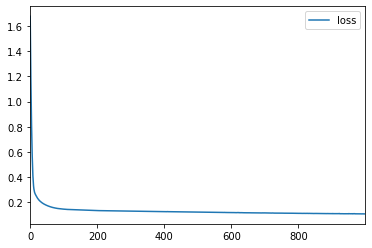

In [27]:
losses.plot()

In [28]:
predictions = model.predict(X)

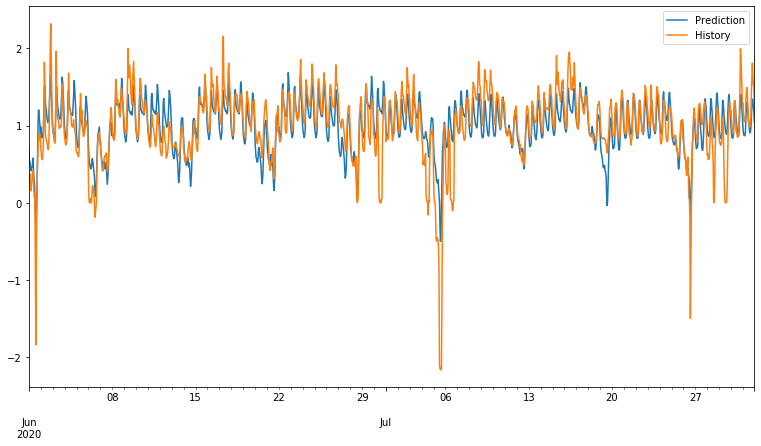

In [29]:
numObs = predictions.shape[0]*predictions.shape[1]
pred_reshape = predictions.reshape(numObs,1)
outcome = y.values.reshape(numObs,1)
pred_vs_outcome = np.concatenate((pred_reshape,outcome), axis=1)
result = pd.DataFrame(data = pred_vs_outcome, columns=['Prediction','History'], index = dateRange)
result['2020-06-01':'2020-07-31'].plot(figsize=(13,7))

In [32]:
#Making prediction based on Normal temperature (i.e. Temperatuure_dev_normal = 0)
X_pred_norm = X.copy()
X_pred_norm.loc[:,'Temperature_dev_normal']=0
predictions_norm = model.predict(X_pred_norm)

#Making prediction based on warm temperature (i.e. Temperatuure_dev_normal = 2)
X_pred_warm = X.copy()
X_pred_warm.loc[:,'Temperature_dev_normal']=2
predictions_warm = model.predict(X_pred_warm)

#Making prediction based on cold temperature (i.e. Temperatuure_dev_normal = -2)
X_pred_cold = X.copy()
X_pred_cold.loc[:,'Temperature_dev_normal']=-2
predictions_cold = model.predict(X_pred_cold)




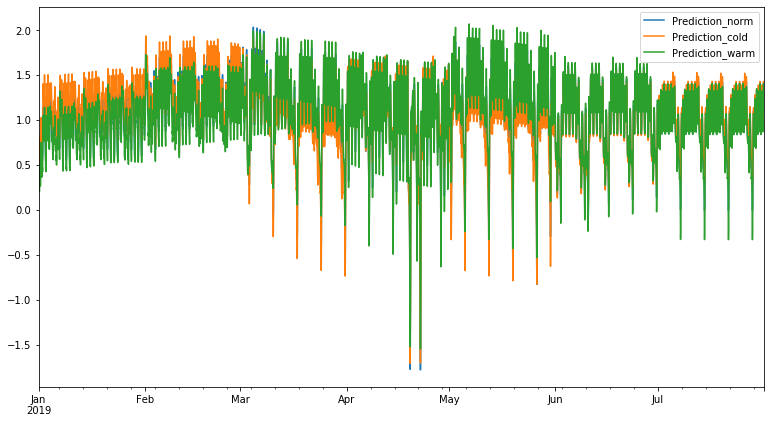

In [49]:
#Plotting predictions
numObs_norm = predictions_norm.shape[0]*predictions_norm.shape[1]
pred_norm_reshape = predictions_norm.reshape(numObs_norm,1)
pred_warm_reshape = predictions_warm.reshape(numObs_norm,1)
pred_cold_reshape = predictions_cold.reshape(numObs_norm,1)

preds = np.concatenate((pred_norm_reshape,pred_cold_reshape), axis=1)
result_preds = pd.DataFrame(data = preds, columns=['Prediction_norm','Prediction_cold'], index = dateRange)
result_preds['Prediction_warm']=pred_warm_reshape
result_preds['2019-01-01':'2019-07-31'].plot(figsize=(13,7))